## Projet BIP :
### Objectifs :

L'objectif de ce projet est de développer une méthode de localisation des noeuds d'arbre dans une image en déterminant leurs caractéristiques, telles que la taille et l'excentricité.

In [1]:
import matplotlib.pyplot as plt
import skimage.io as io 
from scipy.ndimage import binary_fill_holes
from skimage.color import rgb2gray,label2rgb
from skimage.filters import sobel,threshold_otsu,threshold_li,median,gaussian,prewitt
from scipy.ndimage import label as lb
from skimage.measure import regionprops,label,regionprops_table
import skimage.morphology as morpho
import numpy as np
import os
import matplotlib.patches as mpatches
from skimage.filters import threshold_local
from skimage.filters import gaussian
from skimage import img_as_float
from scipy.signal import fftconvolve


In [2]:
def read_images_from_folder(folder_path):
    """
    Cette fonction lit les images à partir d'un dossier et les convertit en niveaux de gris.
    
    Args:
    - folder_path (str): Le chemin du dossier contenant les images.
    
    Returns:
    - images (list): Une liste d'images converties en niveaux de gris.
    """
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg')):  
            img_path = os.path.join(folder_path, filename)
            img = io.imread(img_path)
            img=rgb2gray(img)
            img=img_as_float(img)  
            if img is not None:
                images.append(img)  # Add the image to the list
    return images


In [3]:
folder_path = './Image_data'
image_dataset = read_images_from_folder(folder_path)
#plt.imshow(image_dataset[0],'gray')

### Optimisation de la Détection des Noeuds : Approche par Disjonction de cas
Pour la détection des noeuds, il est apparu évident que l'obtention d'une précision élevée pour les gros noeuds et les petits noeuds simultanément s'avère difficile. Cela résulte de la disparité des filtres appliqués (érosion, ouverture, etc.) sur les images, car dans le cas des petits noeuds, une érosion pourrait induire une perte manifeste d'informations utiles, pouvant même entraîner la non-détection de certains noeuds.

Afin de pallier ce problème de perte d'information et d'optimiser le taux de détection des noeuds, nous avons adopté une approche par cas disjoint. Dans un premier temps, nous évaluons le type de noeud prédominant dans l'image. Ensuite, nous appliquons la méthode de détection des gros noeuds ou celle des petits noeuds en conséquence, permettant ainsi une meilleure adaptation à la diversité des caractéristiques des noeuds présents.

In [9]:
def thresholding_big_knots(image):
    """
    Cette fonction applique une méthode de seuillage pour détecter les gros noeuds d'arbre dans une image.
    
    Args:
    - image (array): L'image d'entrée.
    
    Returns:
    - filtered_regions (list): Une liste de régions (noeuds) filtrées selon leur taille et excentricité.
    """
    min_area = 10000
    max_area = 900000

    threshold_max = (image).max()
    threshold = threshold_max * 0.4

    # Filtre Gaussien
    img_gauss = gaussian(image, sigma=1)

    # Seuillage de l'image
    mask = img_gauss < threshold

    # Application de masques
    fh_mask = binary_fill_holes(mask)
    d_mask = morpho.binary_dilation(fh_mask, footprint=morpho.disk(3))
    e_mask = morpho.binary_erosion(d_mask)

    # Labelisation des régions
    label_image = label(e_mask)
    regions = regionprops(label_image)
    filtered_regions = []
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title('image avec bounding box sur les noeuds')
    ax.imshow(image, 'gray')
    
    for region in regionprops(label_image):
        if min_area < region.area < max_area and 0 <= region.eccentricity < 0.9:
             minr, minc, maxr, maxc = region.bbox
             
             rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
             ax.add_patch(rect)
             centroid = region.centroid
             ax.plot(centroid[1], centroid[0], 'ro', markersize=5)  
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    fig = plt.figure()
    plt.title('mask de binarisation ')
    plt.imshow(label_image)
    plt.show()
    return filtered_regions

## Parametrage de cette detection

Pour eff

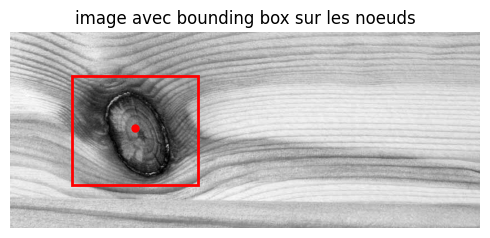

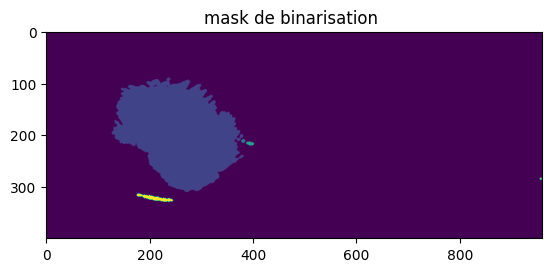

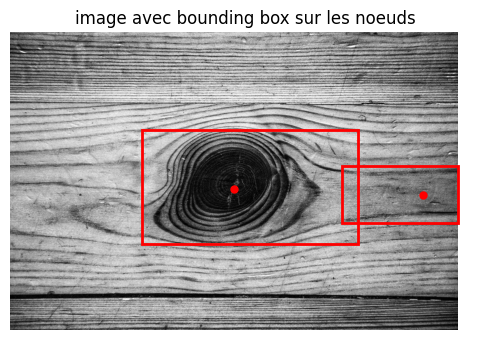

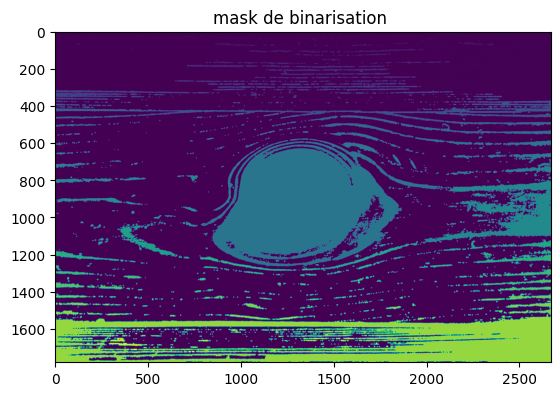

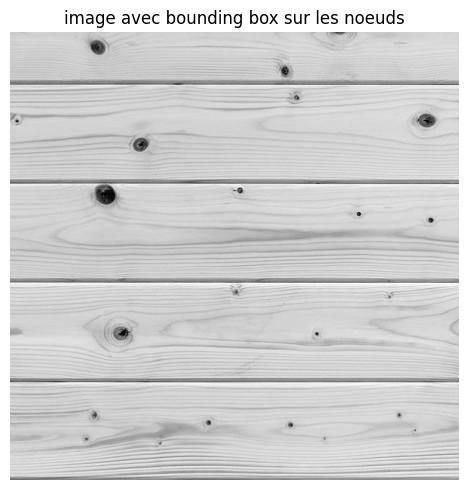

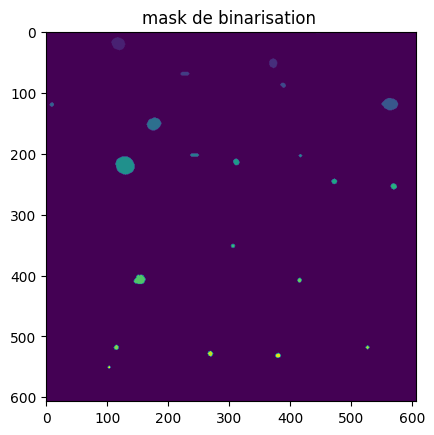

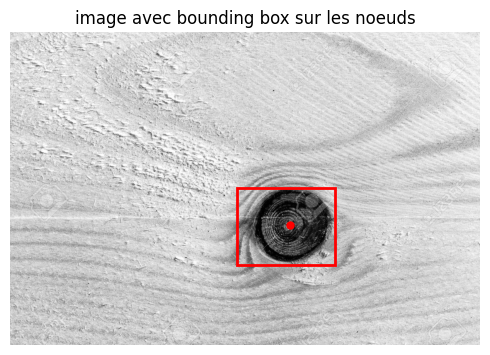

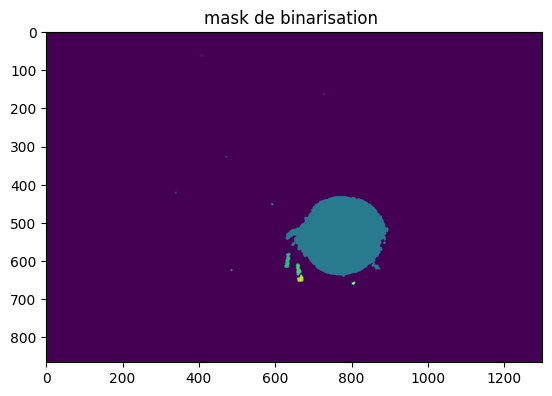

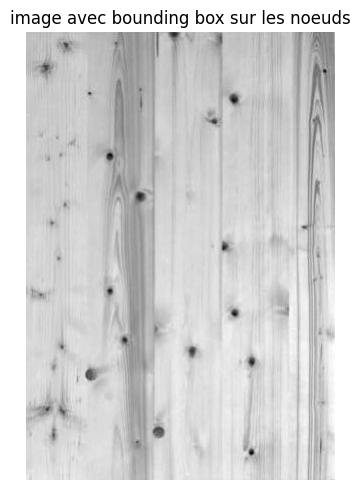

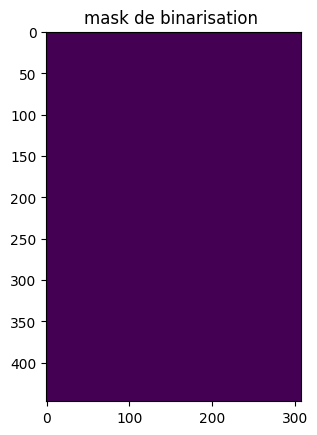

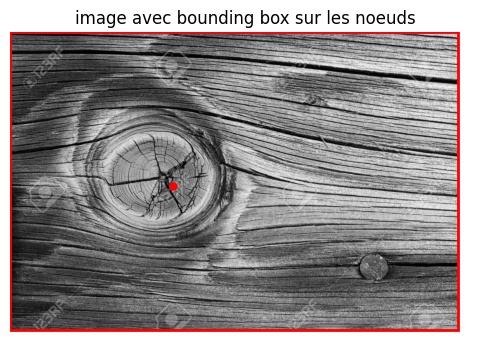

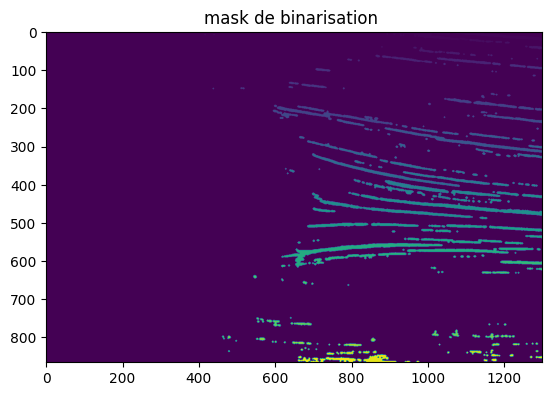

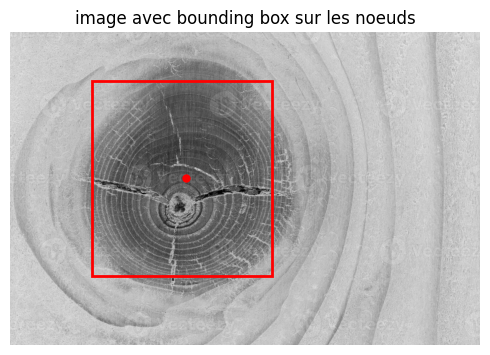

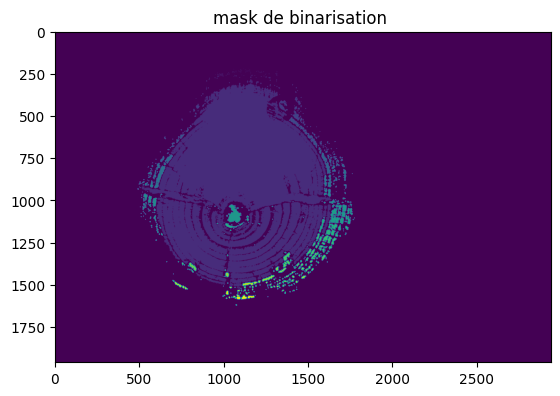

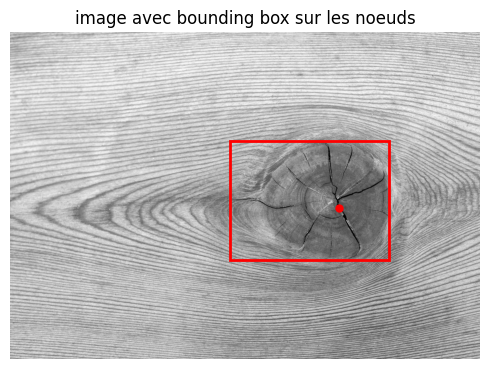

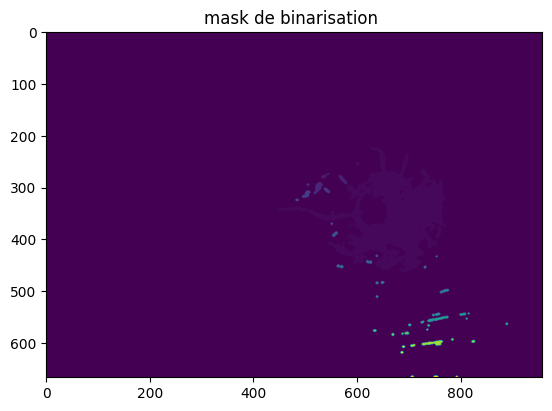

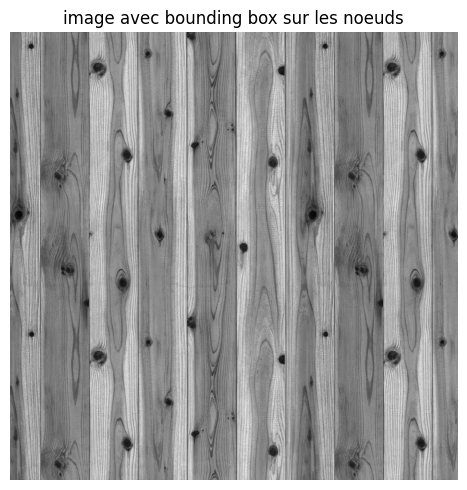

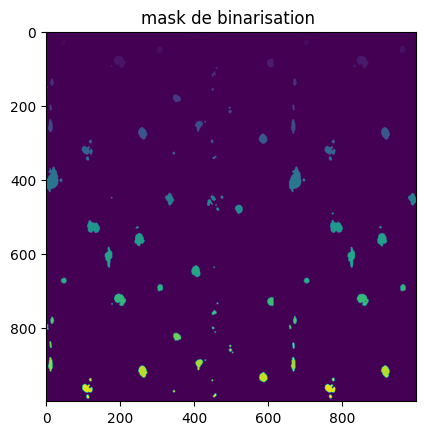

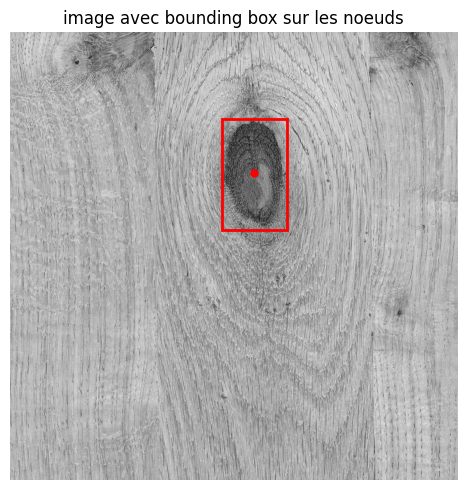

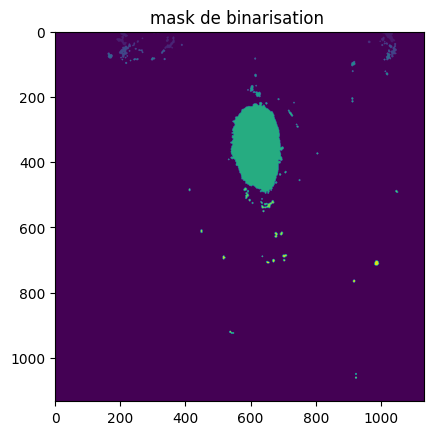

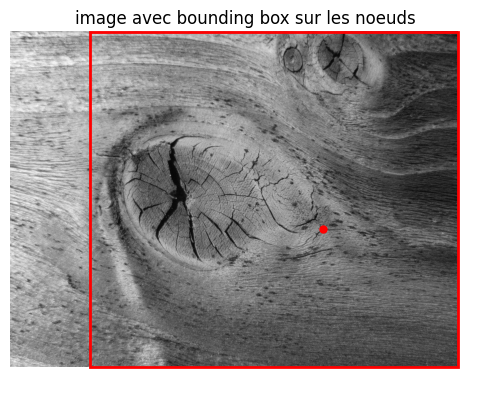

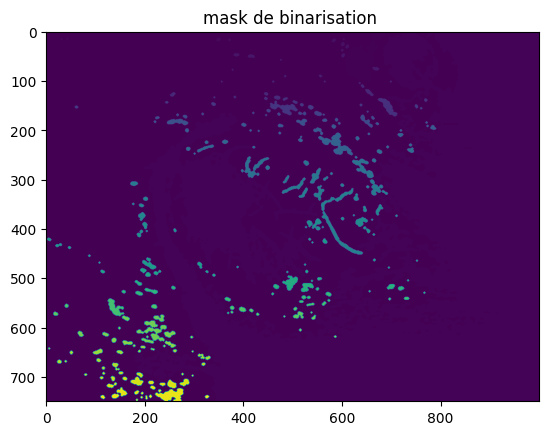

In [15]:
List_properties=[]
for i in range(len(image_dataset)):
    filtered_regionpts=thresholding_big_knots(image_dataset[i])
    List_properties.append(filtered_regionpts)

## Critiques :
 La méthode implémentée ci-dessus procède à une segmentation directe de l'image avec la valeur de seuil (t). Cependant, cette approche ne donne pas une bonne détection de tous les noeuds dans l'image, ce qui est lié à :
 
 **Méthode de seuillage :** Le seuillage utilisé est une méthode simple mais non optimale si l'éclairage et le contraste varient beaucoup. Une approche de filtrage adaptatif ou de variations locales pourrait améliorer la détection. Les images 3 et 8 illustrent bien ce fait.

### Optimisation de la Détection des Noeuds : Approche en utilisant HoughCircles opencv

interactive(children=(FloatSlider(value=180.0, description='t_low:', max=800.0, step=5.0), FloatSlider(value=4…

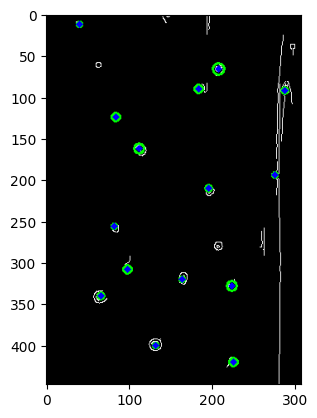

In [32]:
from skimage import feature
from ipywidgets import interact, widgets
from IPython.display import display
from skimage.transform import hough_circle
import cv2

# Supposons que image_dataset soit une liste d'images
img = image_dataset[2]
img1 = cv2.imread('Image_data\48dc02ceb025.jpg')
edges_canny = []
def update_canny(t_low, t_high):
    # Apply GaussianBlur to reduce noise and help the edge detection
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply Sobel operators to get gradients in the x and y directions
    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the magnitude of the gradients
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize the magnitude to be in the range [0, 1]
    gradient_magnitude_normalized = gradient_magnitude / np.max(gradient_magnitude)

    # Apply Canny edge detection
    edges_canny = cv2.Canny((gradient_magnitude_normalized * 255).astype(np.uint8), t_low, t_high)
    cimg = cv2.cvtColor(edges_canny,cv2.COLOR_GRAY2BGR)
    
    circles = cv2.HoughCircles(
    edges_canny,
    cv2.HOUGH_GRADIENT,
    dp=1,  # Inverse ratio of the accumulator resolution to the image resolution
    minDist=23,  # Minimum distance between the centers of the detected circles
    param2=10,  # Threshold for center detection
    minRadius=1,  # Minimum radius to be detected
    maxRadius=20  # Maximum radius to be detected
)
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        
    plt.imshow(cimg)
    plt.show()
    
# Utilisation d'un curseur interactif
t_low_slider = widgets.FloatSlider(value=180, min=0, max=800, step=5, description='t_low:')
t_high_slider = widgets.FloatSlider(value=450, min=0, max=800, step=5, description='t_high:')
interact(update_canny, t_low=t_low_slider, t_high=t_high_slider);

# Affichage initial
update_canny(t_low_slider.value, t_high_slider.value)

In [63]:
# Apply Hough Circle Transform



error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:2269: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'cv::HoughCircles'


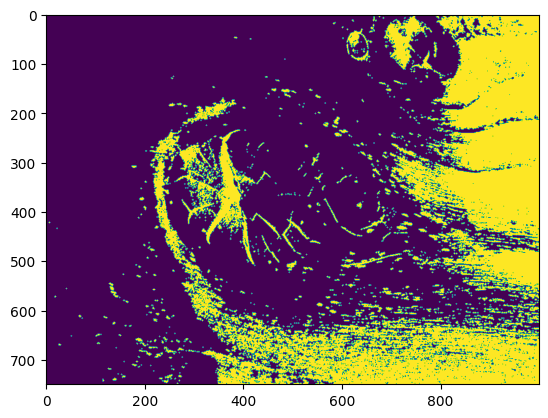

In [101]:
img=image_dataset[7]
#img=median(img,morpho.disk(3))
mask=img<threshold_otsu(img,4)
egdes=morpho.opening(mask,morpho.disk(1))

plt.imshow(egdes)